#### Connect to Colab

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [3]:
%cd '/content/gdrive/My Drive/Recommendation_Final_Project'
! ls

/content/gdrive/.shortcut-targets-by-id/1A6Edl4BpcPowOd1Tlh_plHtAippfCwKC/Recommendation_Final_Project
 checkpoints			      metrics_for_sample_3.csv
'Copy of RS_SessionBased_RNN.ipynb'   metrics_for_sample_4.csv
 dataset			      metrics_for_sample_5.csv
 data_with_new_feature.csv	      metrics_for_sample_6.csv
 evaluation_partial.csv		      metrics_for_sample.csv
 full_metrics_1000_2.csv	      preprocessing.py
 full_metrics_1000.csv		      __pycache__
 full_metrics.csv		      RCSYS_results.csv
 hyperparameters.py		      README.md
 knn.py				      Report.gdoc
 lib				      RS_SessionBased_RNN.ipynb
 LICENSE			      tools.py
 main.py			      trainer.py
 metrics_for_sample_2.csv


#### Requirements

In [ ]:
import argparse
import torch
import lib
import numpy as np
import os
import datetime
import pandas as pd
import unittest
import sys
import pathlib
import urllib
import shutil
import re
import torch
import matplotlib.pyplot as plt
import seaborn as sns

%load_ext autoreload
%autoreload 2

test = unittest.TestCase()
plt.rcParams.update({'font.size': 12})
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

In [19]:
import hyperparameters as hp
import preprocessing as pp
import main
import trainer
import knn

In [6]:
torch.cuda.manual_seed(hp.get_hyperparams()['seed'])

#### Preprocessing Data


##### Creating Test and Train datasetsets

In [ ]:
dataBefore = 'dataset/yoochoose-clicks.dat' 
dataTestBefore = 'dataset/yoochoose-test.dat' 
dataAfter = 'dataset/' 
dayTime = 86400 # Validation Only one day = 86400 seconds

In [ ]:
train = pd.read_csv(dataBefore, sep=',', header=None, usecols=[0,1,2], dtype={0:np.int32, 1:str, 2:np.int64})
train.columns = ['SessionID', 'Time', 'ItemID'] 
train = pp.convert_time(train)
train.head()

,SessionID,Time,ItemID
0,1,1.396868e+09,214536502
1,1,1.396868e+09,214536500
2,1,1.396868e+09,214536506
3,1,1.396868e+09,214577561
4,2,1.396879e+09,214662742


In [ ]:
test = pd.read_csv(dataTestBefore, sep=',', header=None, usecols=[0,1,2], dtype={0:np.int32, 1:str, 2:np.int64})
test.columns = ['SessionID', 'Time', 'ItemID'] 
test = pp.convert_time(test)
test.head()

,SessionID,Time,ItemID
0,5,1.396891e+09,214530776
1,5,1.396891e+09,214530776
2,5,1.396891e+09,214530776
3,10,1.396597e+09,214820942
4,10,1.396598e+09,214826810


In [ ]:
# Remove sessions of length 1
train = pp.removeShortSessions(train)
train = pp.remove_items(train)
train = pp.removeShortSessions(train)

In [ ]:
# In test data only take itemids in test that appear in training
test = test[np.in1d(test.ItemID, train.ItemID)] 
test = pp.removeShortSessions(test)
test.shape

(7925086, 3)

In [ ]:
print('Training Set has', len(train), 'Events, ', train.SessionID.nunique(), 'Sessions, and', train.ItemID.nunique(), 'Items')
train.to_csv(dataAfter + 'recSys15TrainFull.txt', sep='\t', index=False)
print('Testing Set has', len(test), 'Events, ', test.SessionID.nunique(), 'Sessions, and', test.ItemID.nunique(), 'Items\n')
test.to_csv(dataAfter + 'recSys15Test.txt', sep=',', index=False)

Training Set has 31708505 Events,  7981581 Sessions, and 37486 Items
Testing Set has 7925086 Events,  1994993 Sessions, and 34907 Items



##### Splitting Train to train and validation data for hyperparameter optimization

In [ ]:
timeMax = train.Time.max()
sessionMaxTime = train.groupby('SessionID').Time.max()
sessionTrain = sessionMaxTime[sessionMaxTime < (timeMax - dayTime)].index #training split is all sessions that ended before the last 2nd day
sessionValid = sessionMaxTime[sessionMaxTime >= (timeMax - dayTime)].index #validation split is all sessions that ended during the last 2nd day

#Split to train and validation data
trainTR = train[np.in1d(train.SessionID, sessionTrain)]
trainVD = train[np.in1d(train.SessionID, sessionValid)]

#Delete records in validation split where items are not in training split
trainVD = trainVD[np.in1d(trainVD.ItemID, trainTR.ItemID)]
#Delete Sessions in testing split which are less than 2
trainVD = pp.removeShortSessions(trainVD)

#Convert To CSV
print('Training Set has', len(trainTR), 'Events, ', trainTR.SessionID.nunique(), 'Sessions, and', trainTR.ItemID.nunique(), 'Items')
trainTR.to_csv(dataAfter + 'recSys15TrainOnly.txt', sep=',', index=False)
print('Validation Set has', len(trainVD), 'Events, ', trainVD.SessionID.nunique(), 'Sessions, and', trainVD.ItemID.nunique(), 'Items')
trainVD.to_csv(dataAfter + 'recSys15Valid.txt', sep=',', index=False)

Training Set has 31637239 Events,  7966257 Sessions, and 37483 Items
Validation Set has 71222 Events,  15324 Sessions, and 6751 Items


#### Next time, skip Preprocessing Data section and run from here

In [7]:
# #Load data from files created
# dataAfter = 'dataset/'
# trainTR = pd.read_csv(dataAfter + 'recSys15TrainOnly.txt')
# trainVD = pd.read_csv(dataAfter + 'recSys15Valid.txt')
# # test = pd.read_csv(dataAfter + 'recSys15Test.txt')

#### Due to memory restrictions, we also created a smaller dataset for training and validation
Here, we added a new feature to the input that is time a user spend on a single item. 
For item j : 0$\leq$ j$<$n in given session of length n+1 we define time spend on item j to be (time of item j+1) $-$ (time of item j).


In [ ]:
sample = trainTR[(trainTR['SessionID'] < 3000000)]

In [ ]:
# Create additional feature of time spent on single item in a given session - run this one time only!
sample['time_spent'] = 0
adding_sessions = 0
id = 0
for session in sample['SessionID'].unique():
  session_i = sample[sample['SessionID'] == session].copy()
  session_i = session_i.sort_values(by = 'Time')
  session_i = session_i.reset_index()
  
  for j in range(len(session_i)-1):
    sample['time_spent'][j+adding_sessions] = int(session_i['Time'][j+1] - session_i['Time'][j])
  adding_sessions += len(session_i)
  if id % 10000 == 0 :
    print(f'Processing sesison {id}') 
    sample.to_csv('data_with_new_feature.csv', index = False)
  id += 1  

sample.to_csv('data_with_new_feature.csv', index = False)
sample.head()  

In [46]:
#Load new data
df = pd.read_csv('dataset/data_with_new_feature.csv')
df.time_spent = df.time_spent.astype(np.int32)
df.head()

,SessionID,Time,ItemID,time_spent
0,1,1.396868e+09,214536502,180
1,1,1.396868e+09,214536500,37
2,1,1.396868e+09,214536506,133
3,1,1.396868e+09,214577561,0
4,2,1.396879e+09,214662742,41


In [8]:
#Split sample to train and validation
dayTime = 86400 #Validation Only one day = 86400 seconds
dataAfter = 'dataset/' #Path to Processed Dataset Folder

timeMax = df.Time.max()
sessionMaxTime = df.groupby('SessionID').Time.max()
sessionTrain = sessionMaxTime[sessionMaxTime < (timeMax - dayTime)].index #training split is all sessions that ended before the last 2nd day
sessionValid = sessionMaxTime[sessionMaxTime >= (timeMax - dayTime)].index #validation split is all sessions that ended during the last 2nd day
sessionValid
#Split to train and validation data
trainTR_sample = df[np.in1d(df.SessionID, sessionTrain)]
trainVD_sample = df[np.in1d(df.SessionID, sessionValid)]
#Delete records in validation split where items are not in training split
trainVD_sample = trainVD_sample[np.in1d(trainVD_sample.ItemID, trainTR_sample.ItemID)]
#Delete Sessions in testing split which are less than 2
trainVD_sample = pp.removeShortSessions(trainVD_sample)
#Convert To CSV
print('Training Set has', len(trainTR_sample), 'Events, ', trainTR_sample.SessionID.nunique(), 'Sessions, and', trainTR_sample.ItemID.nunique(), 'Items')
trainTR_sample.to_csv(dataAfter + 'train_sample.txt', sep=',', index=False)
print('Validation Set has', len(trainVD_sample), 'Events, ', trainVD_sample.SessionID.nunique(), 'Sessions, and', trainVD_sample.ItemID.nunique(), 'Items')
trainVD_sample.to_csv(dataAfter + 'valid_sample.txt', sep=',', index=False)

Training Set has 8530594 Events,  2117132 Sessions, and 30324 Items
Validation Set has 100414 Events,  27694 Sessions, and 9341 Items


#### Analysis and Visualization

##### Full Training Set

In [ ]:
# Length of sessions
session_length = trainTR.groupby('SessionID')['Time'].count()
session_length.describe()
print(f'Length of average session in train set is: {np.round(session_length.mean(),0)}, with standard deviation : {np.round(session_length.std(),2)} ')
print(f'Lengh of max session in train set is: {np.round(session_length.max(),0)}')

Length of average session in train set is: 4.0, with standard deviation : 3.92 
Lengh of max session in train set is: 200


In [ ]:
print(f'There are {session_length.count()} session in Training')

There are 7966257 session in Training


In [ ]:
# Looking at sessions of average length
limit_to = 9
new_count = session_length[session_length<limit_to].count()
print(f'For visualization on histogram limiting sessions to max length of {limit_to} sessions, covering {np.round(100*new_count/session_length.count(),2)} % of sessions')

Limiting sessions to max length of 9 sessions, covering 92.87 % of sessions


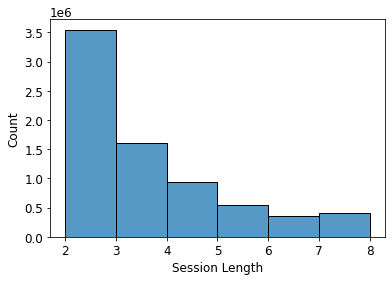

In [ ]:
sns.histplot(session_length[session_length<limit_to],binwidth=1)
plt.xlabel('Session Length')
plt.title('Distribution of Session Lengths')
plt.show()

We can see majority of the sessions are only of length 2. This signifies how little information we have on users during their browse sessions.

##### Partial Training Set
The improved model was training on a smaller dataset due to our limitation in RAM while generating the dataset. The below is an analysis of the partial dataset used. 

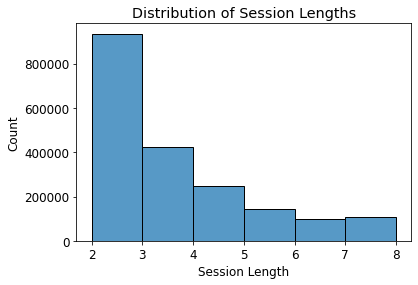

In [29]:
limit_to = 9
session_length = trainTR_sample.groupby('SessionID')['Time'].count()
sns.histplot(session_length[session_length<limit_to],binwidth=1)
plt.xlabel('Session Length')
plt.title('Distribution of Session Lengths')
plt.show()

In [ ]:
max_time = 360
new_count = len(trainTR_sample[trainTR_sample['time_spent']<max_time])
all = len(trainTR_sample)
print(f'For visualization on histogram limiting time spent on item to max time of {limit_to} s, covering {np.round(100*new_count/all,2)} % of items')

For visualization on histogram limiting time spent on item to max time of 9 s, covering 94.17 % of items


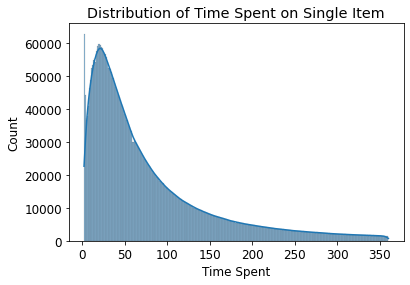

In [ ]:
sns.histplot(trainTR_sample[(trainTR_sample['time_spent'] > 2) & (trainTR_sample['time_spent'] < max_time )]['time_spent'], kde = True)
plt.xlabel('Time Spent')
plt.title('Distribution of Time Spent on Single Item')
plt.show()

We can see that the majority of items were viewed for under 60 seconds. Resembling a log-normal distribution. 

##### Now that we have our data prepared, let's start training the models!

In [ ]:
# Metrics calculated on full datasets - train with trainTR and evaluate with trainVD
# First initiate dataframe to save metrics
final_model_metrics = pd.DataFrame(columns = ['Recall@20', 'MRR@20'])

##### Baseline KNN Model

In [30]:
dataAfter = 'dataset/' #Path to Processed Dataset Folder
trainTR = pd.read_csv(dataAfter + 'recSys15TrainOnly.txt')
trainVD = pd.read_csv(dataAfter + 'recSys15Valid.txt')

In [31]:
KNN_model = knn.ItemKNN()  #Initiate model
KNN_model.fit(trainTR)  #Train with sample data

Training...


  0%|          | 0/37483 [00:00<?, ?it/s]

In [32]:
#Example of prediction returned by KNN
prediction = KNN_model.predict_next(0,2,np.arange(len(trainTR)))
prediction.sort_values(ascending = False).head(10)
#True label is item 3 - not in below results

8996     0.077443
7046     0.063560
1        0.062599
9116     0.059567
0        0.057624
9115     0.042434
9113     0.029832
5543     0.024644
5541     0.021095
12365    0.020591
dtype: float64

In [33]:
recall, mrr = KNN_model.evaluate_sessions(trainTR, trainVD, items=None, cut_off=20)
print(f"Recall = {recall}\n MRR = {mrr}")

Evaluating...


  0%|          | 0/71222 [00:00<?, ?it/s]

Recall = 0.5065297506171956
 MRR = 0.204769896550507


In [35]:
#Add metrics to report
final_model_metrics = pd.DataFrame([[recall, mrr]], columns=['Recall@20', 'MRR@20'], index=['KNN'])
final_model_metrics

,Recall@20,MRR@20
KNN,0.50653,0.20477


#### GRU RNN from article 
Running on full dataset with hyperparameters from article

In [14]:
params = hp.get_hyperparams()

In [15]:
#Put dataframe in DataSet object
train_data = lib.Dataset(os.path.join(params['data_folder'], params['train_data']))
valid_data = lib.Dataset(os.path.join(params['data_folder'], params['valid_data']), itemmap=train_data.itemmap)

In [36]:
input_size = len(train_data.items)
output_size = input_size
coda = torch.cuda.is_available()

losses = ['BPR-max', 'CrossEntropy', 'TOP1-max']
hidden_states = [100, 1000]
df_rnn = pd.DataFrame(columns = ['Recall@20', 'MRR@20'])

#Based on best hyperparameter optimization in main article
params_per_loss = {'TOP1-max': {'batch_size': 50, 'dropout': 0 , 'lr' : 0.01 , 'momentum' : 0 },
               'BPR-max' : {'batch_size': 50, 'dropout': 0 , 'lr' : 0.05 , 'momentum' : 0.2 },
               'CrossEntropy' : {'batch_size': 500, 'dropout': 0 , 'lr' : 0.01 , 'momentum' : 0 }}
epochs = 4
for hs in hidden_states:
  for ls in losses:
    index = f'{ls} {str(hs)}'
    loss_function = lib.LossFunction(loss_type=ls, use_cuda=coda)
    p = params_per_loss[ls]
    model = lib.model.GRU4REC(input_size, hs, output_size, final_act=params['final_act'],
                            num_layers=params['num_layers'], use_cuda=coda, batch_size=p['batch_size'],
                            dropout_input=params['dropout_input'], dropout_hidden=p['dropout'], embedding_dim=params['embedding_dim'])
    #Init weights
    model.init_model(params['sigma'])
    optimizer = lib.optimizer.Optimizer(model.parameters(), optimizer_type=params['optimizer_type'], lr=p['lr'],
                                  weight_decay=params['weight_decay'], momentum=p['momentum'], eps=params['eps'])
    trnr = trainer.Trainer(model, train_data=train_data, eval_data=valid_data, optim=optimizer, loss_func=loss_function, batch_size=p['batch_size'], model_name = 'RNN')
    if hs == 100:
      epochs = 5
    else: #With 100 hidden states the model is too heavy. Training time is too long so limit to 1 epoch
      epochs = 1  
    trnr.train(0, epochs-1)
    
    model.gru.flatten_parameters()
    evaluation = lib.Evaluation(model, loss_function, use_cuda=coda, k = params['k_eval'])
    loss, recall, mrr = evaluation.eval(valid_data, p['batch_size'])
    
    df2 = pd.DataFrame([[recall, mrr]], columns=['Recall@20', 'MRR@20'], index=[index])
    display(df2)
    final_model_metrics = final_model_metrics.append(df2)
    final_model_metrics.to_csv('/content/gdrive/My Drive/Recommendation_Final_Project/RCSYS15_results.csv')

In [ ]:
knn = pd.DataFrame([['KNN', recall, mrr, 'NA']], columns=['Unnamed: 0','Recall@20', 'MRR@20', 'epochs trained'])
knn

,Unnamed: 0,Recall@20,MRR@20,epochs trained
0,KNN,0.506566,0.20477,NA


In [42]:
metrics_full_data =  pd.read_csv('results/RCSYS15_results.csv', index_col='Model')
metrics_full_data

,Recall@20,MRR@20,epochs trained
Model,,,
TOP1-max 100,0.571454,0.25223,4.0
BPR-max 100,0.590924,0.25382,4.0
CrossEntropy 100,0.570445,0.22873,4.0
TOP1-max 1000,0.595563,0.27615,1.0
BPR-max 1000,0.565428,0.23479,1.0
CrossEntropy 1000,0.556422,0.22013,1.0
KNN,0.506566,0.20477,NaN


#### Improvements to GRU RNN data

In [9]:
params = hp.get_hyperparams()

In [10]:
#Put dataframe in DataSet object
dataAfter = 'dataset/'
train_sample = lib.Dataset(os.path.join(dataAfter, 'train_sample.txt'))
valid_sample = lib.Dataset(os.path.join(dataAfter, 'valid_sample.txt'), itemmap=train_sample.itemmap)

In [11]:
metrics_for_sample = pd.DataFrame(columns = ['Recall@20', 'MRR@20'])

##### Running same RNN model with improved dataset that includes an additional feature - time spent on item.
For time contraints we only run on 1 epoch and use train_sample for training model and valid_sample for evaluation. There are 3 sections on running the models, for parameters optimization and the last part contains all the combinations. 

In [12]:
# Improved RNN
input_size = len(train_sample.items)
output_size = input_size 
coda = torch.cuda.is_available()

losses = ['BPR-max'] 
hidden_states = [1000] 
learning_rate = [0.01, 0.05]
momentums = [0, 0.1]
batch_size = [50] 

for l in losses:
  for h in hidden_states:
    for lr in learning_rate:
      for m in momentums:
        for b in batch_size:
          index = f'improved_rnn_{l}_{str(h)}_{str(lr)}_{str(m)}_{str(b)}'
          loss_function = lib.LossFunction(loss_type=l, use_cuda=torch.cuda.is_available()) #cuda is used with cross entropy only
          model_new = lib.model.GRU4REC_improved(input_size, h, output_size, final_act=params['final_act'],
                                      num_layers=params['num_layers'], use_cuda=coda, batch_size=b,
                                      dropout_input=params['dropout_input'], dropout_hidden=0, embedding_dim=params['embedding_dim'])
          model_new.init_model(params['sigma'])
          optimizer = lib.optimizer.Optimizer(model_new.parameters(), optimizer_type=params['optimizer_type'], lr=lr,
                                            weight_decay=params['weight_decay'], momentum=m, eps=params['eps'])
          trainer_new = trainer.Trainer(model_new, train_data=train_sample, eval_data=valid_sample, optim=optimizer, loss_func=loss_function, batch_size=b, model_name = 'improved_RNN')
          epochs = 1
          trainer_new.train(0, epochs-1 )
          model_new.gru.flatten_parameters()
          evaluation = lib.Evaluation(model_new, loss_function, use_cuda=coda, k = params['k_eval'], model_name = 'improved_RNN')
          loss, recall, mrr = evaluation.eval(valid_sample, b)
          print(f'Loss: {loss}, Recall: {recall}, MRR: {mrr}')

          df2 = pd.DataFrame([[recall, mrr]], columns=['Recall@20', 'MRR@20'], index=[index])
          display(df2)
          metrics_for_sample = metrics_for_sample.append(df2)
          metrics_for_sample.to_csv('/content/gdrive/My Drive/Recommendation_Final_Project/metrics_for_sample_4.csv')

Start Epoch # 0


 72%|███████▏  | 1452/2008 [00:07<00:02, 202.11it/s]


Epoch: 0, train loss: 4.2628, loss: 4.2887, recall: 0.5144, mrr: 0.2391, time: 3196.2054595947266


 72%|███████▏  | 1452/2008 [00:07<00:02, 200.96it/s]

Loss: 4.2886842295486405, Recall: 0.5143801652892562, MRR: 0.23911094129311317


,Recall@20,MRR@20
improved_rnn_BPR-max_1000_0.01_0_50,0.51438,0.239111


Start Epoch # 0


 72%|███████▏  | 1452/2008 [00:07<00:02, 199.47it/s]


Epoch: 0, train loss: 4.2628, loss: 4.2901, recall: 0.5222, mrr: 0.2418, time: 3206.148339509964


 72%|███████▏  | 1452/2008 [00:07<00:02, 197.51it/s]

Loss: 4.290109850158376, Recall: 0.5221900826446281, MRR: 0.24181160631977


,Recall@20,MRR@20
improved_rnn_BPR-max_1000_0.01_0.1_50,0.52219,0.241812


Start Epoch # 0


 72%|███████▏  | 1452/2008 [00:07<00:02, 195.59it/s]


Epoch: 0, train loss: 4.2699, loss: 4.3187, recall: 0.1963, mrr: 0.0914, time: 3225.834361553192


 72%|███████▏  | 1452/2008 [00:07<00:02, 197.92it/s]

Loss: 4.318704593608531, Recall: 0.196267217630854, MRR: 0.09135824447730556


,Recall@20,MRR@20
improved_rnn_BPR-max_1000_0.05_0_50,0.196267,0.091358


Start Epoch # 0


 72%|███████▏  | 1452/2008 [00:07<00:02, 196.53it/s]


Epoch: 0, train loss: 4.2676, loss: 4.3100, recall: 0.2403, mrr: 0.1071, time: 3233.6560320854187


 72%|███████▏  | 1452/2008 [00:07<00:02, 199.15it/s]

Loss: 4.309979043059441, Recall: 0.24027548209366392, MRR: 0.10708663298587441


,Recall@20,MRR@20
improved_rnn_BPR-max_1000_0.05_0.1_50,0.240275,0.107087


In [13]:
#Improved RNN
input_size = len(train_sample.items)
output_size = input_size 
coda = torch.cuda.is_available()

losses = ['TOP1-max'] 
hidden_states = [1000] 
learning_rate = [0.01]
momentums = [0] 
batch_size = [20,100,500] 

for l in losses:
  for h in hidden_states:
    for lr in learning_rate:
      for m in momentums:
        for b in batch_size:
          index = f'improved_rnn_{l}_{str(h)}_{str(lr)}_{str(m)}_{str(b)}'
          loss_function = lib.LossFunction(loss_type=l, use_cuda=torch.cuda.is_available()) #cuda is used with cross entropy only
          model_new = lib.model.GRU4REC_improved(input_size, h, output_size, final_act=params['final_act'],
                                      num_layers=params['num_layers'], use_cuda=coda, batch_size=b,
                                      dropout_input=params['dropout_input'], dropout_hidden=0, embedding_dim=params['embedding_dim'])
          model_new.init_model(params['sigma'])
          optimizer = lib.optimizer.Optimizer(model_new.parameters(), optimizer_type=params['optimizer_type'], lr=lr,
                                            weight_decay=params['weight_decay'], momentum=m, eps=params['eps'])
          trainer_new = trainer.Trainer(model_new, train_data=train_sample, eval_data=valid_sample, optim=optimizer, loss_func=loss_function, batch_size=b, model_name = 'improved_RNN')
          epochs = 1
          trainer_new.train(0, epochs-1 )
          model_new.gru.flatten_parameters()
          evaluation = lib.Evaluation(model_new, loss_function, use_cuda=coda, k = params['k_eval'], model_name = 'improved_RNN')
          loss, recall, mrr = evaluation.eval(valid_sample, b)
          print(f'Loss: {loss}, Recall: {recall}, MRR: {mrr}')

          df2 = pd.DataFrame([[recall, mrr]], columns=['Recall@20', 'MRR@20'], index=[index])
          display(df2)
          metrics_for_sample = metrics_for_sample.append(df2)
          metrics_for_sample.to_csv('/content/gdrive/My Drive/Recommendation_Final_Project/metrics_for_sample_4.csv')

Start Epoch # 0


 72%|███████▏  | 3633/5020 [00:11<00:04, 322.47it/s]


Epoch: 0, train loss: 0.0442, loss: 0.0446, recall: 0.6004, mrr: 0.2788, time: 6960.654095411301


 72%|███████▏  | 3633/5020 [00:11<00:04, 320.37it/s]

Loss: 0.044643673415178116, Recall: 0.6003715937241949, MRR: 0.2788390322715791


,Recall@20,MRR@20
improved_rnn_TOP1-max_1000_0.01_0_20,0.600372,0.278839


Start Epoch # 0


 72%|███████▏  | 724/1004 [00:05<00:02, 134.46it/s]


Epoch: 0, train loss: 0.0085, loss: 0.0087, recall: 0.5977, mrr: 0.2800, time: 1966.001707315445


 72%|███████▏  | 724/1004 [00:05<00:02, 134.39it/s]

Loss: 0.008655606029369966, Recall: 0.5976795580110497, MRR: 0.2800364563066656


,Recall@20,MRR@20
improved_rnn_TOP1-max_1000_0.01_0_100,0.59768,0.280036


Start Epoch # 0


 71%|███████   | 142/200 [00:04<00:01, 34.98it/s]


Epoch: 0, train loss: 0.0017, loss: 0.0017, recall: 0.5986, mrr: 0.2790, time: 947.4554991722107


 71%|███████   | 142/200 [00:04<00:01, 35.44it/s]

Loss: 0.0017213401569932385, Recall: 0.5985774647887323, MRR: 0.279027714275978


,Recall@20,MRR@20
improved_rnn_TOP1-max_1000_0.01_0_500,0.598577,0.279028


In [38]:
#Improved RNN
input_size = len(train_sample.items)
output_size = input_size 
coda = torch.cuda.is_available()

losses = ['TOP1-max', 'BPR-max']
hidden_states = [100, 1000] 
learning_rate = [0.01, 0.02, 0.05, 0.001] 
momentums = [0, 0.1] 
batch_size = [10,20,50,100,500] 

for l in losses:
  for h in hidden_states:
    for lr in learning_rate:
      for m in momentums:
        for b in batch_size:
          index = f'improved_rnn_{l}_{str(h)}_{str(lr)}_{str(m)}_{str(b)}'
          loss_function = lib.LossFunction(loss_type=l, use_cuda=torch.cuda.is_available()) #cuda is used with cross entropy only
          model_new = lib.model.GRU4REC_improved(input_size, h, output_size, final_act=params['final_act'],
                                      num_layers=params['num_layers'], use_cuda=coda, batch_size=b,
                                      dropout_input=params['dropout_input'], dropout_hidden=0, embedding_dim=params['embedding_dim'])
          model_new.init_model(params['sigma'])
          optimizer = lib.optimizer.Optimizer(model_new.parameters(), optimizer_type=params['optimizer_type'], lr=lr,
                                            weight_decay=params['weight_decay'], momentum=m, eps=params['eps'])
          trainer_new = trainer.Trainer(model_new, train_data=train_sample, eval_data=valid_sample, optim=optimizer, loss_func=loss_function, batch_size=b, model_name = 'improved_RNN')
          epochs = 1
          trainer_new.train(0, epochs-1 )
          model_new.gru.flatten_parameters()
          evaluation = lib.Evaluation(model_new, loss_function, use_cuda=coda, k = params['k_eval'], model_name = 'improved_RNN')
          loss, recall, mrr = evaluation.eval(valid_sample, b)
          print(f'Loss: {loss}, Recall: {recall}, MRR: {mrr}')

          df2 = pd.DataFrame([[recall, mrr]], columns=['Recall@20', 'MRR@20'], index=[index])
          display(df2)
          metrics_for_sample = metrics_for_sample.append(df2)
          metrics_for_sample.to_csv('/content/gdrive/My Drive/Recommendation_Final_Project/metrics_for_sample_7.csv')

##### Evaluation metrics for Improved models run on the sample dataset

In [43]:
improved_metrics_for_sample = pd.read_csv('results/improved_metrics_for_sample.csv', index_col='Model')
improved_metrics_for_sample

,Recall@20,MRR@20
Model,,
improved_rnn_TOP1-max_1000_0.01_0_100,0.597238,0.280375
improved_rnn_TOP1-max_1000_0.01_0_100,0.597680,0.280036
improved_rnn_TOP1-max_1000_0.01_0_20,0.601363,0.279767
improved_rnn_TOP1-max_1000_0.01_0.1_50,0.597672,0.279449
improved_rnn_TOP1-max_1000_0.01_0_50,0.597824,0.279356
improved_rnn_TOP1-max_1000_0.01_0_500,0.598577,0.279028
improved_rnn_TOP1-max_1000_0.01_0_20,0.600372,0.278839
improved_rnn_TOP1-max_1000_0.01_0_500,0.598563,0.278665
improved_rnn_TOP1-max_1000_0.02_0_50,0.593251,0.271075


##### For comparison with improved RNN above, we ran original RNN without processing the new feature. The model was trained on the smaller dataset (train_sample) with only 2M session and evaluated on same dataset as improved RNN. 

In [14]:
#Original RNN
input_size = len(train_sample.items)
output_size = input_size 
coda = torch.cuda.is_available()

losses = ['BPR-max'] # 'TOP1-max', 
hidden_states = [1000] #100 
learning_rate = [0.01, 0.05]
momentums = [0, 0.1]
batch_size = [50] 

for l in losses:
  for h in hidden_states:
    for lr in learning_rate:
      for m in momentums:
        for b in batch_size:
          index = f'original_rnn_{l}_{str(h)}_{str(lr)}_{str(m)}_{str(b)}'
          loss_function = lib.LossFunction(loss_type=l, use_cuda=torch.cuda.is_available()) #cuda is used with cross entropy only
          model_new = lib.model.GRU4REC(input_size, h, output_size, final_act=params['final_act'],
                                      num_layers=params['num_layers'], use_cuda=coda, batch_size=b,
                                      dropout_input=params['dropout_input'], dropout_hidden=0, embedding_dim=params['embedding_dim'])
          model_new.init_model(params['sigma'])
          optimizer = lib.optimizer.Optimizer(model_new.parameters(), optimizer_type=params['optimizer_type'], lr=lr,
                                            weight_decay=params['weight_decay'], momentum=m, eps=params['eps'])
          trainer_new = trainer.Trainer(model_new, train_data=train_sample, eval_data=valid_sample, optim=optimizer, loss_func=loss_function, batch_size=b, model_name = 'RNN')
          epochs = 1
          trainer_new.train(0, epochs-1)
          model_new.gru.flatten_parameters()
          evaluation = lib.Evaluation(model_new, loss_function, use_cuda=coda, k = params['k_eval'], model_name = 'RNN')
          loss, recall, mrr = evaluation.eval(valid_sample, b)
          print(f'Loss: {loss}, Recall: {recall}, MRR: {mrr}')

          df2 = pd.DataFrame([[recall, mrr]], columns=['Recall@20', 'MRR@20'], index=[index])
          display(df2)
          metrics_for_sample = metrics_for_sample.append(df2)
          metrics_for_sample.to_csv('/content/gdrive/My Drive/Recommendation_Final_Project/metrics_for_sample_2.csv')

Start Epoch # 0


 72%|███████▏  | 1452/2008 [00:06<00:02, 238.60it/s]


Epoch: 0, train loss: 4.2519, loss: 4.2772, recall: 0.5546, mrr: 0.2544, time: 3055.8543837070465


 72%|███████▏  | 1452/2008 [00:06<00:02, 239.22it/s]

Loss: 4.277212755082396, Recall: 0.5546418732782369, MRR: 0.2543777903854929


,Recall@20,MRR@20
original_rnn_BPR-max_1000_0.01_0_50,0.554642,0.254378


Start Epoch # 0


 72%|███████▏  | 1452/2008 [00:06<00:02, 238.67it/s]


Epoch: 0, train loss: 4.2519, loss: 4.2775, recall: 0.5639, mrr: 0.2576, time: 3063.259776353836


 72%|███████▏  | 1452/2008 [00:06<00:02, 239.43it/s]

Loss: 4.277461617774543, Recall: 0.5639118457300276, MRR: 0.25755363812069754


,Recall@20,MRR@20
original_rnn_BPR-max_1000_0.01_0.1_50,0.563912,0.257554


Start Epoch # 0


 72%|███████▏  | 1452/2008 [00:06<00:02, 237.97it/s]


Epoch: 0, train loss: 4.2321, loss: 4.2688, recall: 0.5079, mrr: 0.2082, time: 3060.905586242676


 72%|███████▏  | 1452/2008 [00:06<00:02, 237.07it/s]

Loss: 4.268794024942991, Recall: 0.5079063360881543, MRR: 0.20821224095571797


,Recall@20,MRR@20
original_rnn_BPR-max_1000_0.05_0_50,0.507906,0.208212


Start Epoch # 0


 72%|███████▏  | 1452/2008 [00:06<00:02, 238.28it/s]


Epoch: 0, train loss: 4.2321, loss: 4.2670, recall: 0.5281, mrr: 0.2194, time: 3056.5890505313873


 72%|███████▏  | 1452/2008 [00:06<00:02, 238.04it/s]

Loss: 4.267017145458989, Recall: 0.5281129476584021, MRR: 0.2193778739118379


,Recall@20,MRR@20
original_rnn_BPR-max_1000_0.05_0.1_50,0.528113,0.219378


##### Evaluation metrics for original models run on the sample dataset

In [44]:
original_metrics_for_sample = pd.read_csv('results/original_metrics_for_sample.csv', index_col='Model')
original_metrics_for_sample

,Recall@20,MRR@20
Model,,
original_rnn_BPR-max_100_0.01_0.1_50,0.395826,0.163122
original_rnn_BPR-max_100_0.01_0_50,0.373127,0.158051
original_rnn_BPR-max_100_0.05_0.1_50,0.589242,0.262170
original_rnn_BPR-max_100_0.05_0_50,0.586129,0.259099
original_rnn_BPR-max_1000_0.01_0.1_50,0.563912,0.257554
original_rnn_BPR-max_1000_0.01_0_50,0.562700,0.257198
original_rnn_BPR-max_1000_0.05_0.1_50,0.528113,0.219378
original_rnn_BPR-max_1000_0.05_0_50,0.507906,0.208212
original_rnn_TOP1-max_100_0.01_0.1_50,0.537879,0.241293


##### For comarison, we trained the KNN model on the sample dataset. The model was trained on the smaller dataset (train_sample) with only 2M session and evaluated on same dataset as improved RNN. 

In [17]:
dataAfter = 'dataset/' #Path to Processed Dataset Folder
trainTR = pd.read_csv(dataAfter + 'train_sample.txt')
trainVD = pd.read_csv(dataAfter + 'valid_sample.txt')

In [20]:
KNN_model = knn.ItemKNN()  #Initiate model
KNN_model.fit(trainTR) 

recall, mrr = KNN_model.evaluate_sessions(trainTR, trainVD, items=None, cut_off=20)
print(f"Recall = {recall}\n MRR = {mrr}")

Training...


  0%|          | 0/30324 [00:00<?, ?it/s]

Evaluating...


  0%|          | 0/100414 [00:00<?, ?it/s]

Recall = 0.5076595159515952
 MRR = 0.2317201854168625


#### Credits
Portions of this code were taken from the following contributors:
1. https://github.com/hidasib/GRU4Rec/blob/master/baselines.py
2. https://github.com/hungthanhpham94/GRU4REC-pytorch

Dataset was taken from RecSys 2015 Challenge:

https://www.kaggle.com/chadgostopp/recsys-challenge-2015